# Exploratory

In [1]:
query="""
SELECT
  weight_pounds,
  is_male,
  mother_age,
  plurality,
  gestation_weeks
FROM
  publicdata.samples.natality
WHERE year > 2000
"""
from google.cloud import bigquery
df = bigquery.Client().query(query + " LIMIT 100").to_dataframe()
df.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks
0,7.936641,False,30,1,38
1,8.624484,True,34,1,39
2,6.937947,True,23,1,39
3,6.935743,True,18,1,39
4,8.318041,False,23,1,40


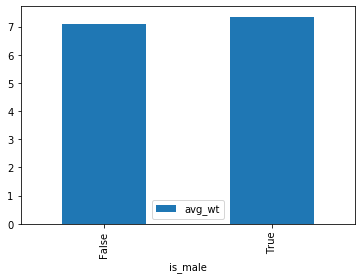

In [3]:
def get_distinct_values(column_name):
  sql = """
SELECT
  {0},
  COUNT(1) AS num_babies,
  AVG(weight_pounds) AS avg_wt
FROM
  publicdata.samples.natality
WHERE
  year > 2000
GROUP BY
  {0}
  """.format(column_name)
  return bigquery.Client().query(sql).to_dataframe()

df = get_distinct_values('is_male')
df.plot(x='is_male', y='avg_wt', kind='bar');

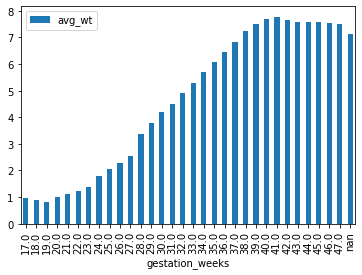

In [4]:
df = get_distinct_values('gestation_weeks')
df = df.sort_values('gestation_weeks')
df.plot(x='gestation_weeks', y='avg_wt', kind='bar');

In [ ]:
# https://cloud.google.com/dataproc/docs/tutorials/bigquery-sparkml

# Data Preparation

In [ ]:
#!/usr/bin/env python

# Copyright 2018 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


def run_natality_tutorial(override_values={}):
    # [START bigquery_query_natality_tutorial]
    """Create a Google BigQuery linear regression input table.
    In the code below, the following actions are taken:
    * A new dataset is created "natality_regression."
    * A query is run against the public dataset,
        bigquery-public-data.samples.natality, selecting only the data of
        interest to the regression, the output of which is stored in a new
        "regression_input" table.
    * The output table is moved over the wire to the user's default project via
        the built-in BigQuery Connector for Spark that bridges BigQuery and
        Cloud Dataproc.
    """

    from google.cloud import bigquery

    # Create a new Google BigQuery client using Google Cloud Platform project
    # defaults.
    client = bigquery.Client()

    # Prepare a reference to a new dataset for storing the query results.
    dataset_id = 'natality_regression'
    # [END bigquery_query_natality_tutorial]
    # To facilitate testing, we replace values with alternatives
    # provided by the testing harness.
    dataset_id = override_values.get("dataset_id", dataset_id)
    # [START bigquery_query_natality_tutorial]

    dataset = bigquery.Dataset(client.dataset(dataset_id))

    # Create the new BigQuery dataset.
    dataset = client.create_dataset(dataset)

    # In the new BigQuery dataset, create a reference to a new table for
    # storing the query results.
    table_ref = dataset.table('regression_input')

    # Configure the query job.
    job_config = bigquery.QueryJobConfig()

    # Set the destination table to the table reference created above.
    job_config.destination = table_ref

    # Set up a query in Standard SQL, which is the default for the BigQuery
    # Python client library.
    # The query selects the fields of interest.
    query = """
        SELECT
            weight_pounds, mother_age, father_age, gestation_weeks,
            weight_gain_pounds, apgar_5min
        FROM
            `bigquery-public-data.samples.natality`
        WHERE
            weight_pounds IS NOT NULL
            AND mother_age IS NOT NULL
            AND father_age IS NOT NULL
            AND gestation_weeks IS NOT NULL
            AND weight_gain_pounds IS NOT NULL
            AND apgar_5min IS NOT NULL
    """

    # Run the query.
    query_job = client.query(query, job_config=job_config)
    query_job.result()  # Waits for the query to finish
    # [END bigquery_query_natality_tutorial]


if __name__ == '__main__':
    run_natality_tutorial()

# Model preparation script

In [ ]:
# --jars=gs://spark-lib/bigquery/spark-bigquery-latest.jar

In [2]:
%%writefile natality_sparkml.py
"""Run a linear regression using Apache Spark ML.

In the following PySpark (Spark Python API) code, we take the following actions:

  * Load a previously created linear regression (BigQuery) input table
    into our Cloud Dataproc Spark cluster as an RDD (Resilient
    Distributed Dataset)
  * Transform the RDD into a Spark Dataframe
  * Vectorize the features on which the model will be trained
  * Compute a linear regression using Spark ML

"""

from __future__ import print_function
from pyspark.context import SparkContext
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import LinearRegression
from pyspark.sql.session import SparkSession
# The imports, above, allow us to access SparkML features specific to linear
# regression as well as the Vectors types.


# Define a function that collects the features of interest
# (mother_age, father_age, and gestation_weeks) into a vector.
# Package the vector in a tuple containing the label (`weight_pounds`) for that
# row.
def vector_from_inputs(r):
  return (r["weight_pounds"], Vectors.dense(float(r["mother_age"]),
                                            float(r["father_age"]),
                                            float(r["gestation_weeks"]),
                                            float(r["weight_gain_pounds"]),
                                            float(r["apgar_5min"])))

sc = SparkContext()
spark = SparkSession(sc)

# Read the data from BigQuery as a Spark Dataframe.
natality_data = spark.read.format("bigquery").option(
    "table", "natality_regression.regression_input").load()
# Create a view so that Spark SQL queries can be run against the data.
natality_data.createOrReplaceTempView("natality")

# As a precaution, run a query in Spark SQL to ensure no NULL values exist.
sql_query = """
SELECT *
from natality
where weight_pounds is not null
and mother_age is not null
and father_age is not null
and gestation_weeks is not null
"""
clean_data = spark.sql(sql_query)

# Create an input DataFrame for Spark ML using the above function.
training_data = clean_data.rdd.map(vector_from_inputs).toDF(["label",
                                                             "features"])
training_data.cache()

# Construct a new LinearRegression object and fit the training data.
lr = LinearRegression(maxIter=5, regParam=0.2, solver="normal")
model = lr.fit(training_data)
# Print the model summary.
print("Coefficients:" + str(model.coefficients))
print("Intercept:" + str(model.intercept))
print("R^2:" + str(model.summary.r2))
model.summary.residuals.show()



Overwriting natality_sparkml.py


# Create Cluster

In [7]:
!gcloud dataproc clusters create cluster-5488 --region=us-central1 \
    --master-machine-type=n1-standard-2 \
    --master-boot-disk-size=50GB \
    --num-workers=2 \
    --worker-machine-type=n1-standard-2 \
    --worker-boot-disk-size=50GB \
    --scopes bigquery,cloud-platform

Waiting on operation [projects/my-kaggle-competitions/regions/us-central1/operations/fb3973c2-1dca-3575-b83b-40a8b3322210].
Waiting for cluster creation operation...                                      
Waiting for cluster creation operation...done.                                 
Created [https://dataproc.googleapis.com/v1/projects/my-kaggle-competitions/regions/us-central1/clusters/cluster-5488] Cluster placed in zone [us-central1-f].


In [13]:
# do not run it yet!!
!gcloud dataproc clusters delete --quiet cluster-5488 --region=us-central1

Waiting on operation [projects/my-kaggle-competitions/regions/us-central1/operations/c49f31cd-3751-3041-b649-2da454d2d161].
Waiting for cluster deletion operation...done.                                 
Deleted [https://dataproc.googleapis.com/v1/projects/my-kaggle-competitions/regions/us-central1/clusters/cluster-5488].


# Submit Train Job

In [27]:
PROJECT_NAME="<>"
myBucket="gs://<>/"
cluster_name="cluster-5488"
cluster_region="us-central1"

In [24]:
!gsutil cp natality_sparkml.py $myBucket/natality/

Copying file://natality_sparkml.py [Content-Type=text/x-python]...
/ [1 files][  2.5 KiB/  2.5 KiB]                                                
Operation completed over 1 objects/2.5 KiB.                                      


In [25]:
!gsutil ls $myBucket/natality/

gs://mkc_transfer/myWorkspace/bigML/natality/natality_sparkml.py


In [15]:
!gsutil ls -lh gs://spark-lib/bigquery/spark-bigquery-latest.jar

 30.93 MiB  2020-04-27T17:12:34Z  gs://spark-lib/bigquery/spark-bigquery-latest.jar
TOTAL: 1 objects, 32436661 bytes (30.93 MiB)


## submit train job

In [28]:
!gcloud dataproc jobs submit pyspark $myBucket/natality/natality_sparkml.py \
    --cluster=$cluster_name \
    --region=$cluster_region \
    --files=$myBucket/natality/natality_sparkml.py \
    --jars=gs://spark-lib/bigquery/spark-bigquery-latest.jar

Job [ad1b3ae44d124012ba2f1d22564c4f0b] submitted.
Waiting for job output...
20/06/08 22:47:09 INFO org.spark_project.jetty.util.log: Logging initialized @4244ms
20/06/08 22:47:09 INFO org.spark_project.jetty.server.Server: jetty-9.3.z-SNAPSHOT, build timestamp: unknown, git hash: unknown
20/06/08 22:47:09 INFO org.spark_project.jetty.server.Server: Started @4336ms
20/06/08 22:47:09 INFO org.spark_project.jetty.server.AbstractConnector: Started ServerConnector@111afbd{HTTP/1.1,[http/1.1]}{0.0.0.0:4040}
20/06/08 22:47:09 WARN org.apache.spark.scheduler.FairSchedulableBuilder: Fair Scheduler configuration file not found so jobs will be scheduled in FIFO order. To use fair scheduling, configure pools in fairscheduler.xml or set spark.scheduler.allocation.file to a file that contains the configuration.
20/06/08 22:47:10 INFO org.apache.hadoop.yarn.client.RMProxy: Connecting to ResourceManager at cluster-5488-m/10.128.0.25:8032
20/06/08 22:47:11 INFO org.apache.hadoop.yarn.client.AHSProxy: C